Use GPyTorch
Use Spectral Mixture kernel

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
if torch.cuda.device_count() > 0:
    torch.cuda.set_device(0)
    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [4]:
df = pd.read_csv("../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [6]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

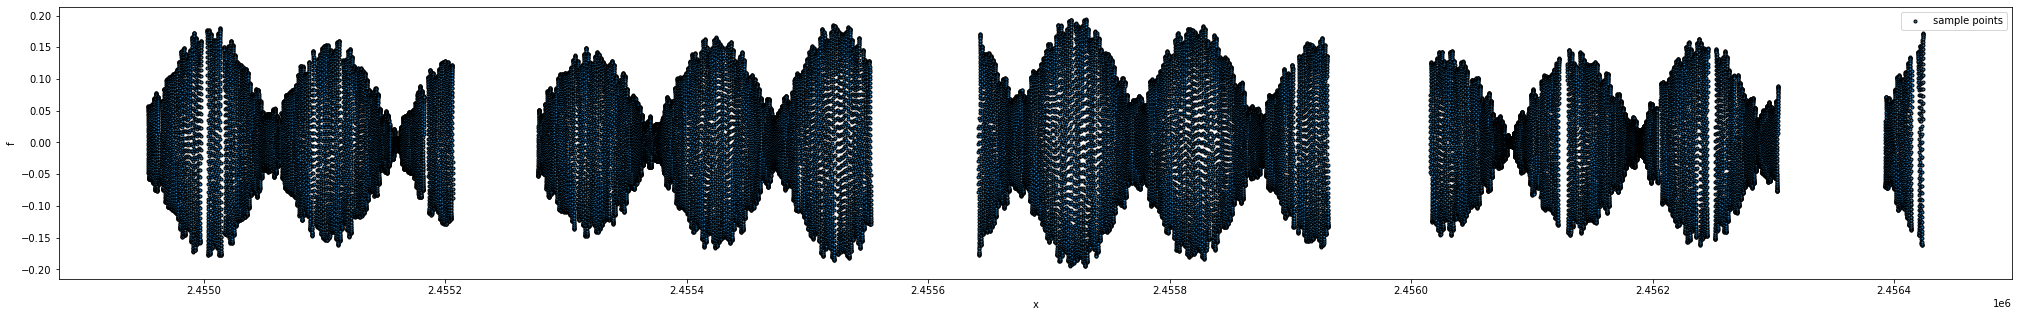

In [7]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [8]:
N_part=5000

In [9]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X[:N_part], Y[:N_part], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [10]:
def plot_kernel_samples(covariance_matrix, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    Y_sample = covariance_matrix.sample(nr_of_samples)
    N = cov_matrix.W.shape[0]
    for i in range(nr_of_samples):
        plt.plot(range(N), Y_sample[i])

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [11]:
X_part=torch.tensor(X[:N_part])
Y_part=torch.tensor(Y[:N_part])

In [12]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [13]:
# normalize labels
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

In [14]:
X_part,Y_part

(tensor([2454953.5392, 2454953.5597, 2454953.5801,  ..., 2455066.3955,
         2455066.4159, 2455066.4363], dtype=torch.float64),
 tensor([0.6691, 0.6666, 0.6608,  ..., 0.5282, 0.4839, 0.4367],
        dtype=torch.float64))

In [15]:
Y_part.cpu().numpy().mean()

-2.4868995751603507e-17

In [40]:
NUM_MIXTURES=10

In [42]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
#        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
#        self.covar_module = gpytorch.kernels.RBFKernel()
#        self.covar_module.lengthscale = 0.1
#        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
        self.covar_module = gpytorch.kernels.PeriodicKernel()
        self.covar_module.period_length = 1.7
        self.covar_module = gpytorch.kernels.ScaleKernel(self.covar_module)
       
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=NUM_MIXTURES)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(X_part, Y_part, likelihood)
model = SpectralMixtureGPModel(X_part, Y_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

Move data and models to the GPU

In [43]:
if torch.cuda.device_count() > 0:
    X_part = X_part.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part = Y_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [44]:
training_iter = 10

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.15)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   period: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        0,
#        model.covar_module.period_length.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/10 - Loss: 1.416   period: 0.000   noise: 0.693
Iter 2/10 - Loss: 1.147   period: 0.000   noise: 0.621
Iter 3/10 - Loss: 0.935   period: 0.000   noise: 0.570
Iter 4/10 - Loss: 0.813   period: 0.000   noise: 0.517
Iter 5/10 - Loss: 0.738   period: 0.000   noise: 0.464
Iter 6/10 - Loss: 0.662   period: 0.000   noise: 0.414
Iter 7/10 - Loss: 0.598   period: 0.000   noise: 0.367
Iter 8/10 - Loss: 0.531   period: 0.000   noise: 0.324
Iter 9/10 - Loss: 0.468   period: 0.000   noise: 0.285
Iter 10/10 - Loss: 0.405   period: 0.000   noise: 0.250


In [45]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))

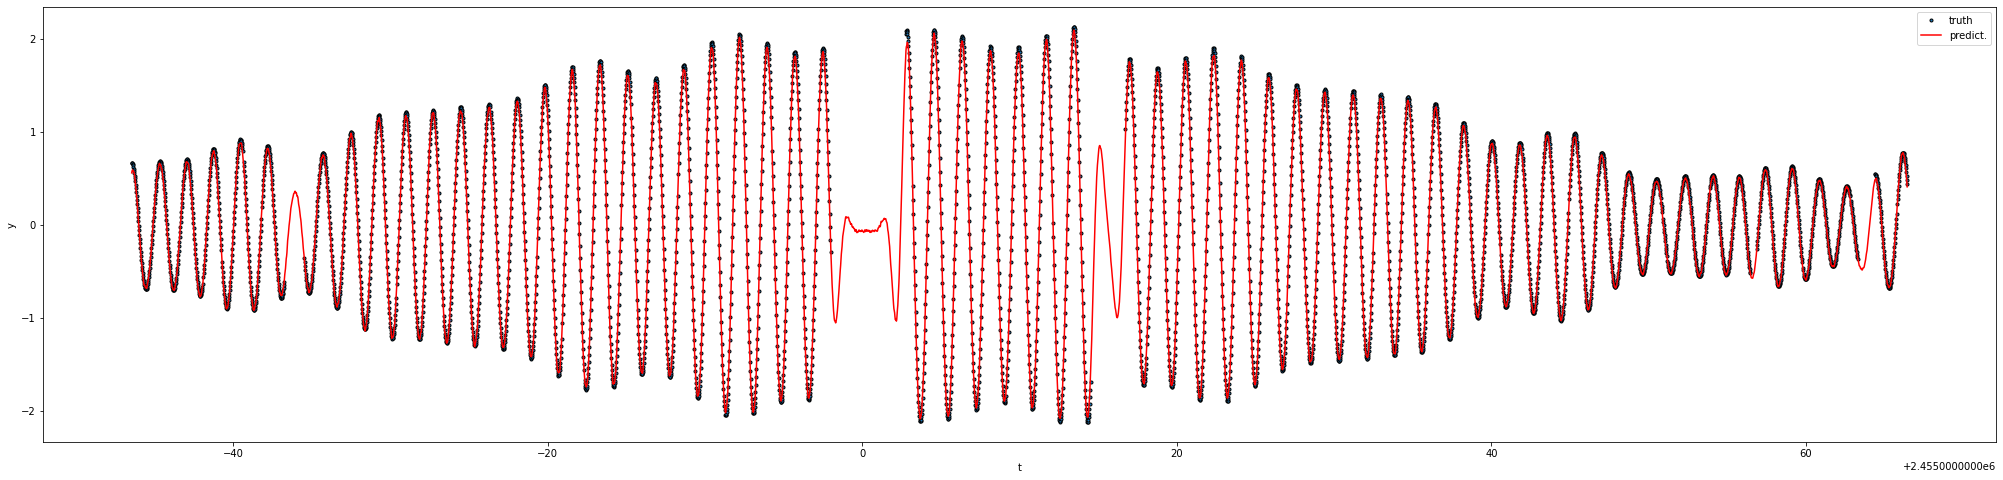

In [46]:
with torch.no_grad():
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

In [47]:
model.covar_module

SpectralMixtureKernel(
  (raw_mixture_scales_constraint): Positive()
  (raw_mixture_means_constraint): Positive()
  (raw_mixture_weights_constraint): Positive()
)

In [48]:
model.covar_module.mixture_scales, model.covar_module.mixture_means

(tensor([[[0.0036]],
 
         [[0.0151]],
 
         [[0.0104]],
 
         [[0.0017]],
 
         [[0.0034]],
 
         [[0.2004]],
 
         [[0.0039]],
 
         [[0.0032]],
 
         [[0.0075]],
 
         [[0.2444]]], dtype=torch.float64, grad_fn=<SoftplusBackward0>),
 tensor([[[ 5.7033]],
 
         [[ 7.5123]],
 
         [[ 4.7648]],
 
         [[ 5.5647]],
 
         [[10.6536]],
 
         [[12.4772]],
 
         [[ 2.3431]],
 
         [[ 9.4599]],
 
         [[ 6.1718]],
 
         [[ 0.6340]]], dtype=torch.float64, grad_fn=<SoftplusBackward0>))

In [23]:
residuals = Y_part.cpu()-observed_pred.mean.cpu().numpy()

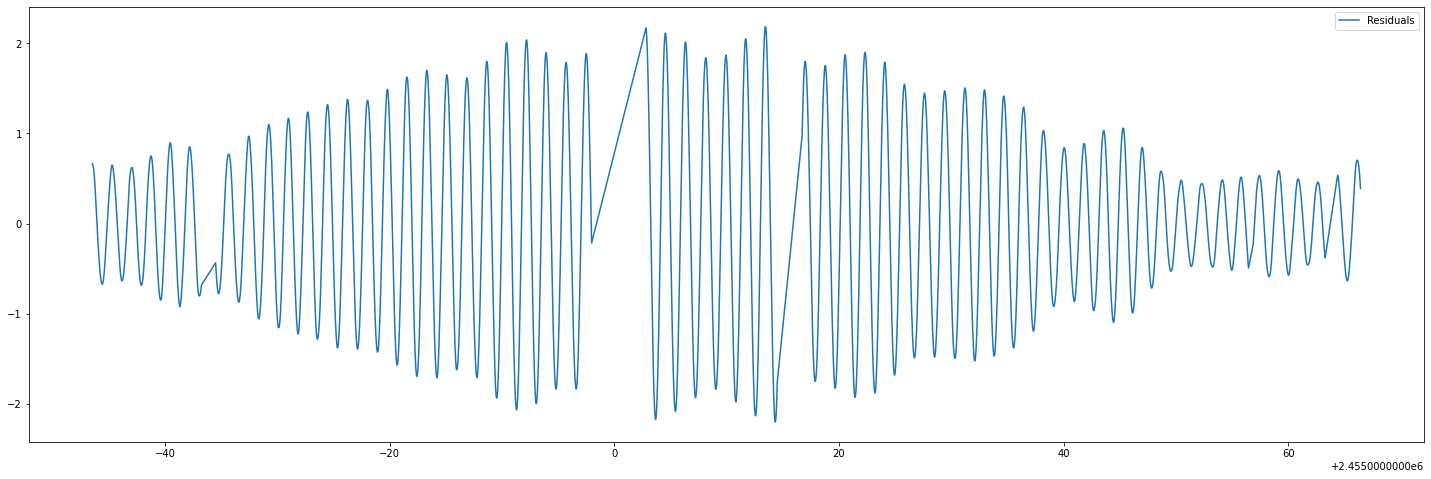

In [24]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part.cpu(), residuals, "-")
plt.legend(labels=["Residuals"])

### RMSE

In [25]:
train_y, observed_pred.mean

NameError: name 'train_y' is not defined

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))
    
np.sqrt(np.nanmean((observed_pred.mean.cpu().numpy()-train_y.cpu().numpy())**2))